<a href="https://colab.research.google.com/github/sohamthirty/Stock-Price-Prediction-with-Sentiment-Analysis/blob/main/Stock_Price_ProphetModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Use Prophet Model to forecast close price

Reference links:

https://www.youtube.com/watch?v=03H2_ekdv2I

https://hareeshpb.medium.com/stock-prediction-using-prophet-python-525710e1ab0c

https://medium.com/mlearning-ai/multivariate-time-series-forecasting-using-fbprophet-66147f049e66

In [10]:
# -- Not needed --
#!pip install pystan==2.19.1.1
#!pip install --upgrade holidays pystan
#!pip install fbprophet

In [11]:
!pip install prophet

In [12]:
!pip install pmdarima

In [13]:
import pandas as pd
import datetime as dt
import pandas_datareader.data as pdr
import os
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from prophet import Prophet
#from fbprophet import Prophet

In [14]:
yf.pdr_override()
y_symbols = ['AAPL', 'GOOG', 'AMZN', 'TSLA', 'MSFT']

In [15]:
startdate = dt.datetime(2015,1,1)
enddate = dt.datetime(2021,1, 1)

### ANALYZE GOOGLE STOCK

In [16]:
data = pdr.get_data_yahoo(['GOOG'], start='2015-01-01', end='2019-12-31')
data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,26.378078,26.490770,26.133251,26.168653,26.168653,28951268
2015-01-05,26.091366,26.144720,25.582764,25.623152,25.623152,41196796
2015-01-06,25.679497,25.738087,24.983908,25.029282,25.029282,57998800
2015-01-07,25.280592,25.292759,24.914099,24.986401,24.986401,41301082
2015-01-08,24.831326,25.105074,24.482782,25.065184,25.065184,67071641


In [17]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1.257000e+03
mean,45.649916,46.038350,45.260461,45.663827,45.663827,3.415121e+07
std,11.523511,11.629350,11.441770,11.539933,11.539933,1.697418e+07
min,24.664783,24.730902,24.311253,24.560070,24.560070,6.950000e+06
25%,36.463501,36.737000,36.116798,36.448002,36.448002,2.426200e+07
50%,46.477001,46.694000,46.172249,46.467999,46.467999,2.976400e+07
75%,55.632999,56.210999,55.183250,55.756500,55.756500,3.899600e+07
max,68.167503,68.250000,67.633499,68.058502,68.058502,2.232980e+08


<Axes: xlabel='Date'>

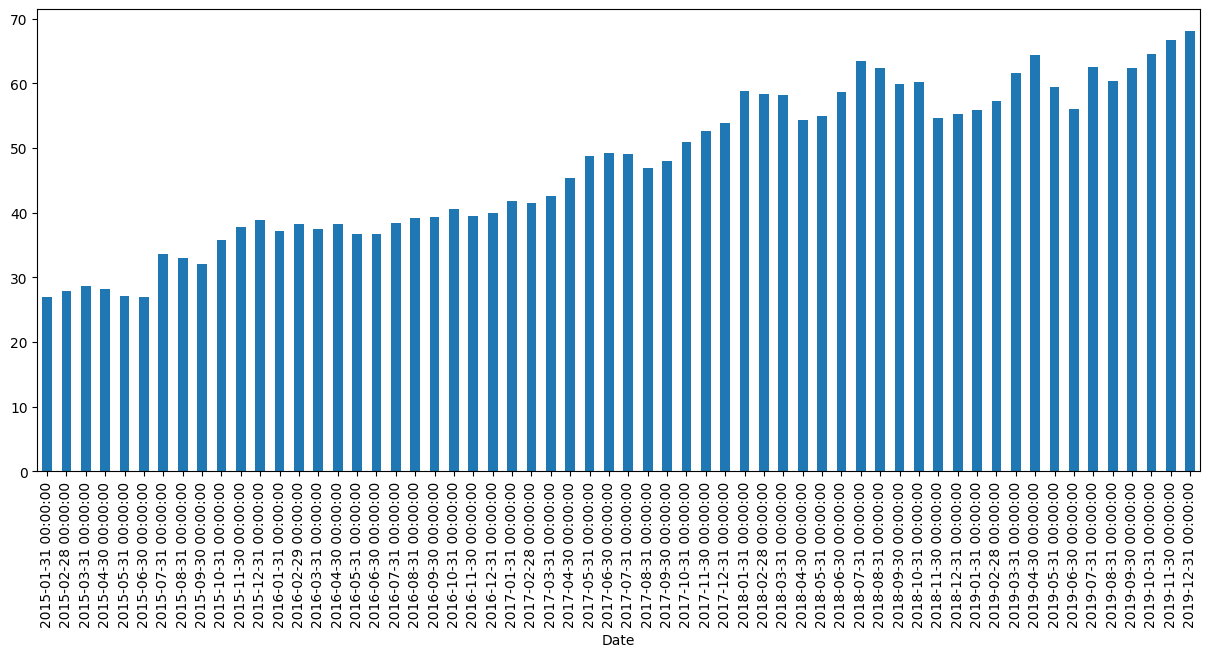

In [18]:
data.Close.resample(rule = 'M').max().plot(kind = 'bar', figsize = (15, 6))

Text(0, 0.5, 'Prices')

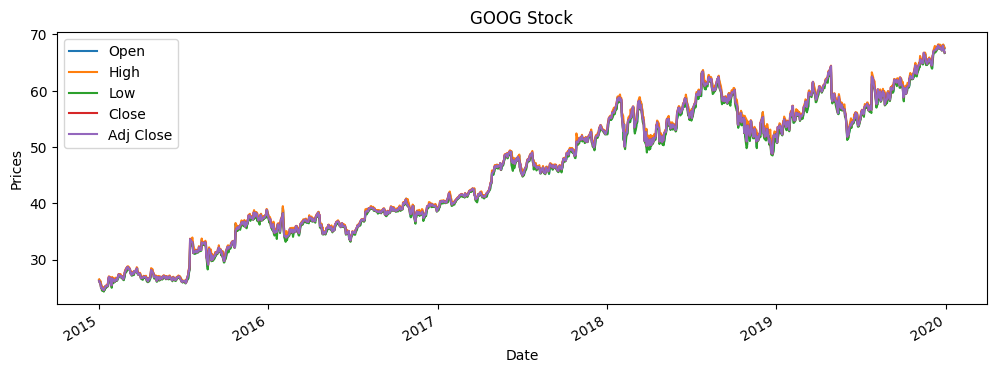

In [19]:
data.iloc[:, :-1].plot(figsize = (12, 4))
plt.title('GOOG Stock')
plt.ylabel('Prices')

<Axes: xlabel='Date'>

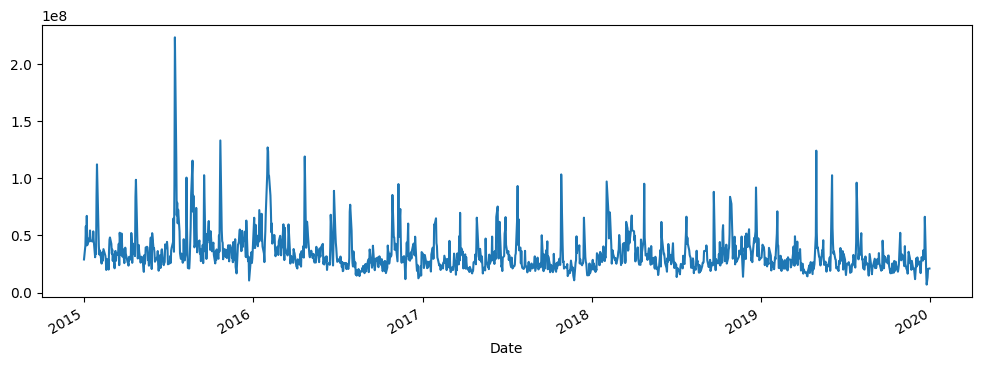

In [20]:
data.Volume.plot(figsize = (12, 4))

array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>], dtype=object)

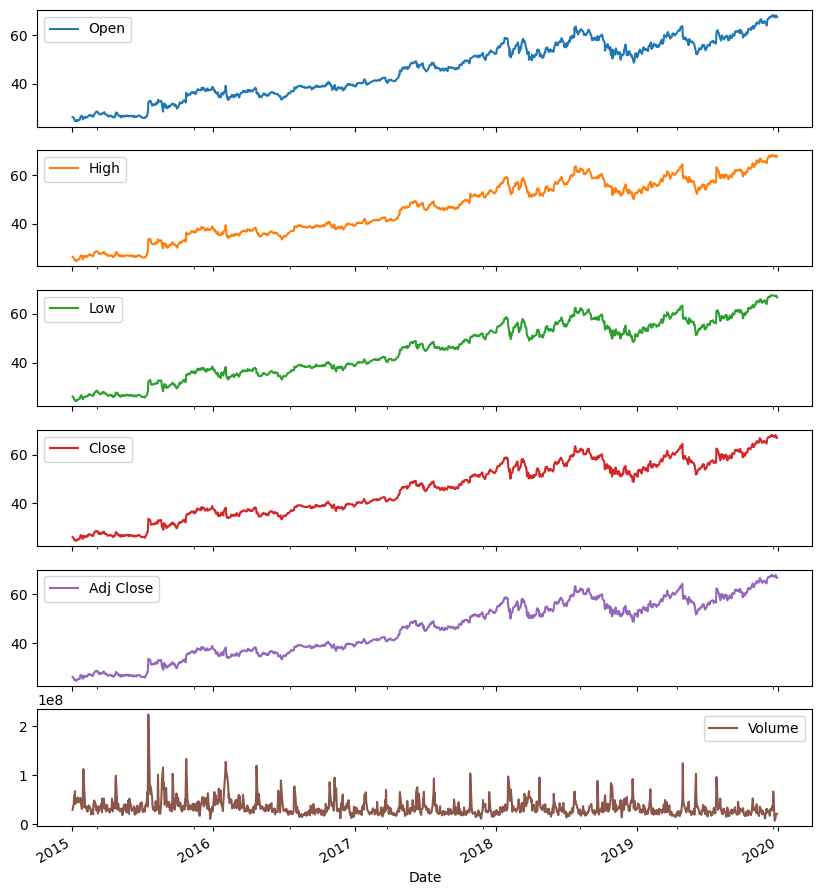

In [21]:
data.plot(subplots = True, figsize = (10, 12))

Lets look at the close value of the stock

<Axes: xlabel='Date'>

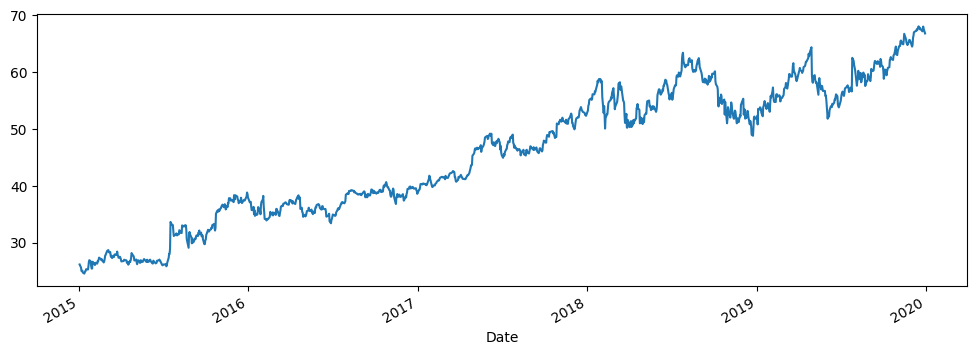

In [22]:
data.Close.plot(figsize = (12, 4))

Text(0.5, 1.0, 'Distribution of close prices over the days')

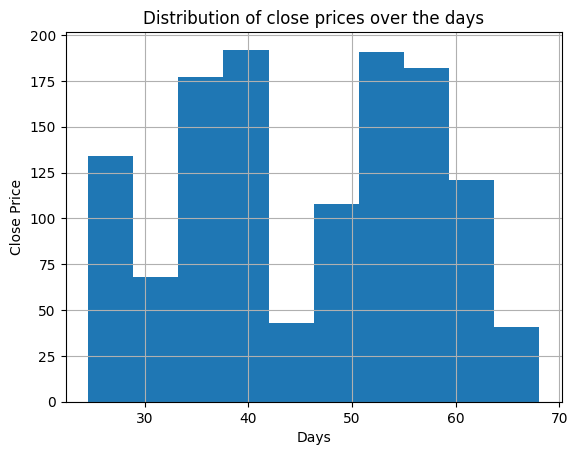

In [23]:
data.Close.hist()
plt.ylabel('Close Price')
plt.xlabel('Days')
plt.title('Distribution of close prices over the days')

In [24]:
data.Close.rolling(10).mean()

Date
2015-01-02          NaN
2015-01-05          NaN
2015-01-06          NaN
2015-01-07          NaN
2015-01-08          NaN
                ...    
2019-12-23    67.555800
2019-12-24    67.550300
2019-12-26    67.627200
2019-12-27    67.635300
2019-12-30    67.576849
Name: Close, Length: 1257, dtype: float64

## UNIVARIATE PROPHET MODEL - PREDICT NEXT YEAR

In [25]:
df_prophet = data
df_prophet = df_prophet.reset_index()
df_prophet

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,26.378078,26.490770,26.133251,26.168653,26.168653,28951268
1,2015-01-05,26.091366,26.144720,25.582764,25.623152,25.623152,41196796
2,2015-01-06,25.679497,25.738087,24.983908,25.029282,25.029282,57998800
3,2015-01-07,25.280592,25.292759,24.914099,24.986401,24.986401,41301082
4,2015-01-08,24.831326,25.105074,24.482782,25.065184,25.065184,67071641
...,...,...,...,...,...,...,...
1252,2019-12-23,67.793503,67.989998,67.325500,67.442001,67.442001,17662000
1253,2019-12-24,67.425003,67.513000,67.139000,67.178001,67.178001,6950000
1254,2019-12-26,67.308502,68.066353,67.223503,68.019997,68.019997,13350000
1255,2019-12-27,68.149498,68.226501,67.465500,67.594498,67.594498,20768000


In [26]:
df_prophet = df_prophet[['Date','Close']]
df_prophet.columns = ['ds','y']
df_prophet

,ds,y
0,2015-01-02,26.168653
1,2015-01-05,25.623152
2,2015-01-06,25.029282
3,2015-01-07,24.986401
4,2015-01-08,25.065184
...,...,...
1252,2019-12-23,67.442001
1253,2019-12-24,67.178001
1254,2019-12-26,68.019997
1255,2019-12-27,67.594498


In [27]:
m = Prophet(daily_seasonality=True)
m.fit(df_prophet) # Training
future = m.make_future_dataframe(periods=365) # predict next 365 days (2021)
forecast = m.predict(future) # Predictions
pd.options.display.max_columns = None
print(forecast.tail(2))

DEBUG:cmdstanpy:input tempfile: /tmp/tmp4bs0pn2m/4zb3jqqd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4bs0pn2m/28jyiyxx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38646', 'data', 'file=/tmp/tmp4bs0pn2m/4zb3jqqd.json', 'init=/tmp/tmp4bs0pn2m/28jyiyxx.json', 'output', 'file=/tmp/tmp4bs0pn2m/prophet_model9f7o_8k5/prophet_model-20231103202026.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:20:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:20:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


             ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
1620 2020-12-28  79.048540   69.410640   86.446177    70.413334    87.390754   
1621 2020-12-29  79.081937   69.121345   86.649712    70.425469    87.461850   

      additive_terms  additive_terms_lower  additive_terms_upper     daily  \
1620       -1.014553             -1.014553             -1.014553 -1.549227   
1621       -1.025074             -1.025074             -1.025074 -1.549227   

      daily_lower  daily_upper    weekly  weekly_lower  weekly_upper  \
1620    -1.549227    -1.549227 -0.123265     -0.123265     -0.123265   
1621    -1.549227    -1.549227 -0.104591     -0.104591     -0.104591   

        yearly  yearly_lower  yearly_upper  multiplicative_terms  \
1620  0.657939      0.657939      0.657939                   0.0   
1621  0.628743      0.628743      0.628743                   0.0   

      multiplicative_terms_lower  multiplicative_terms_upper       yhat  
1620                        

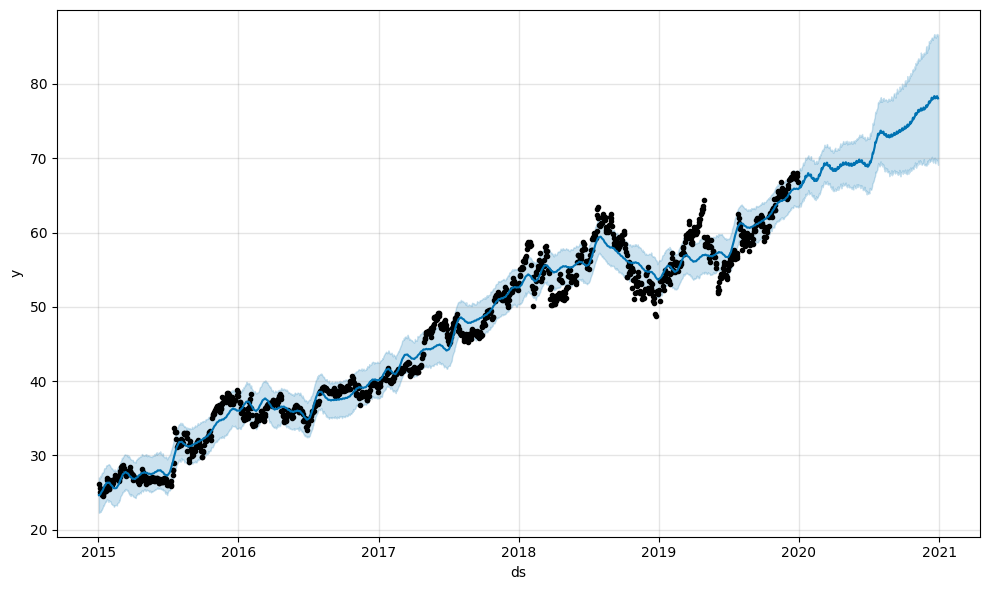

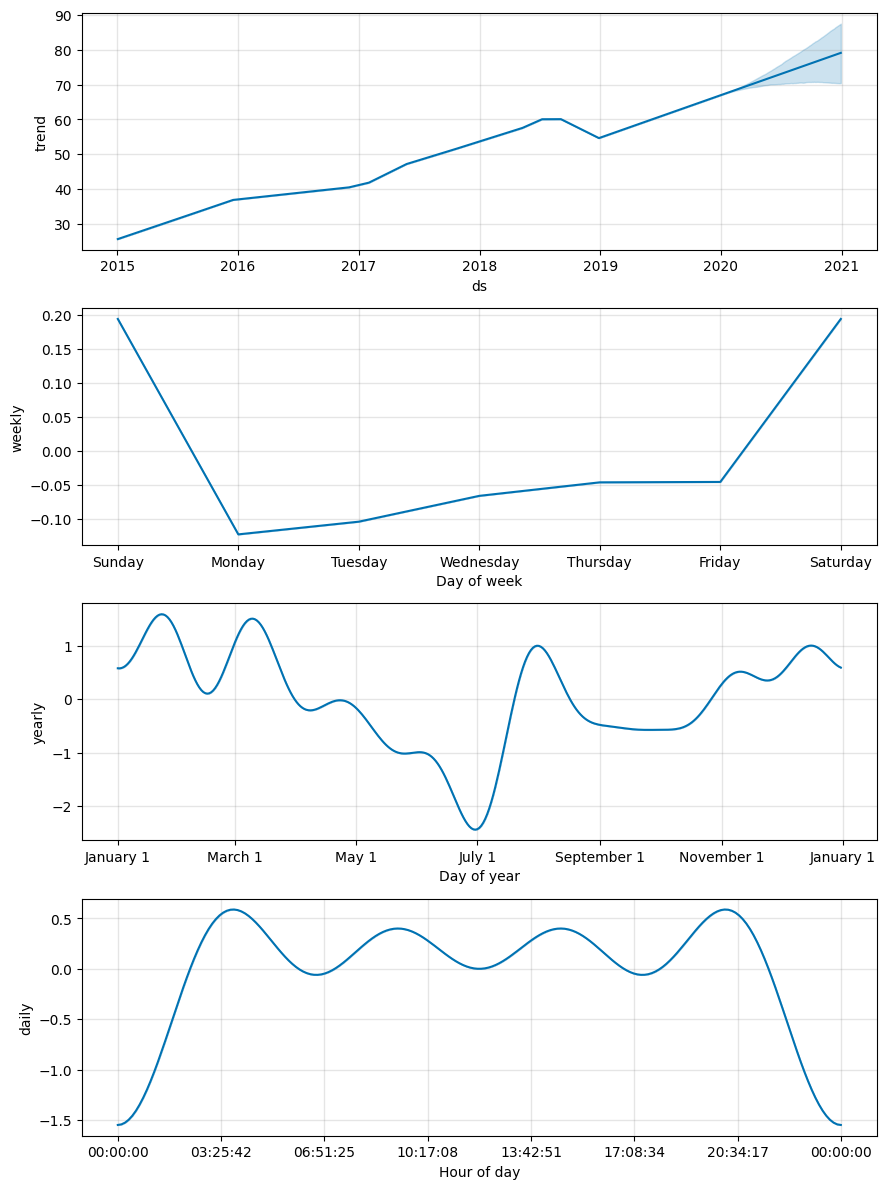

In [28]:
figure1 = m.plot(forecast)
figure2 = m.plot_components(forecast)

In [29]:
from prophet.plot import plot_plotly
plot_plotly(m,forecast)

## UNIVARIATE PROPHET  

## TRAIN : 2015 - 2018
## TEST : 2019

In [30]:
train1 = df_prophet[df_prophet['ds'] <= '2018-12-31']
test1 = df_prophet[df_prophet['ds'] >= '2019-01-01']

In [31]:
test1

,ds,y
1006,2019-01-02,52.292500
1007,2019-01-03,50.803001
1008,2019-01-04,53.535500
1009,2019-01-07,53.419498
1010,2019-01-08,53.813999
...,...,...
1252,2019-12-23,67.442001
1253,2019-12-24,67.178001
1254,2019-12-26,68.019997
1255,2019-12-27,67.594498


In [32]:
m1 = Prophet(daily_seasonality=True)
m1.fit(train1) # Training
future1 = m1.make_future_dataframe(periods=365) # predict next 365 days (2019)
forecast1 = m1.predict(future1) # Predictions
pd.options.display.max_columns = None
print(forecast1.tail(2))

DEBUG:cmdstanpy:input tempfile: /tmp/tmp4bs0pn2m/vhhjr7st.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4bs0pn2m/8wlapdqu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9696', 'data', 'file=/tmp/tmp4bs0pn2m/vhhjr7st.json', 'init=/tmp/tmp4bs0pn2m/8wlapdqu.json', 'output', 'file=/tmp/tmp4bs0pn2m/prophet_modelbtspznak/prophet_model-20231103202034.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:20:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:20:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


             ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
1369 2019-12-30  51.808622   36.467144   67.964752    37.004686    68.534197   
1370 2019-12-31  51.804372   36.304646   68.586246    36.942754    68.585543   

      additive_terms  additive_terms_lower  additive_terms_upper    daily  \
1369       -0.156504             -0.156504             -0.156504  1.44772   
1370       -0.135427             -0.135427             -0.135427  1.44772   

      daily_lower  daily_upper    weekly  weekly_lower  weekly_upper  \
1369      1.44772      1.44772  0.018225      0.018225      0.018225   
1370      1.44772      1.44772  0.062870      0.062870      0.062870   

        yearly  yearly_lower  yearly_upper  multiplicative_terms  \
1369 -1.622448     -1.622448     -1.622448                   0.0   
1370 -1.646017     -1.646017     -1.646017                   0.0   

      multiplicative_terms_lower  multiplicative_terms_upper       yhat  
1369                         0.

In [33]:
plot_plotly(m1,forecast1)

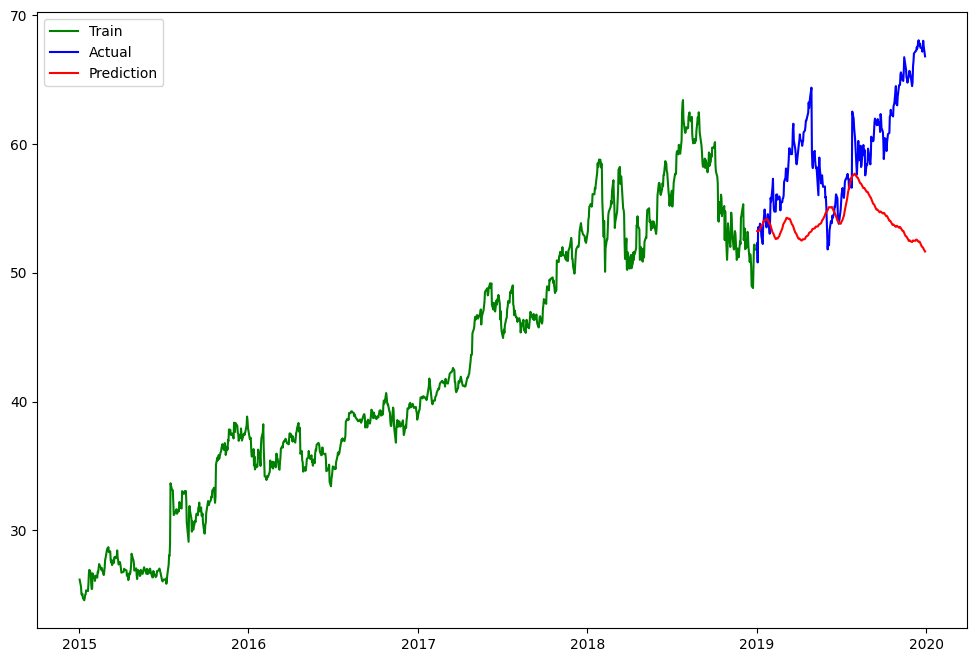

In [34]:
plt.figure(figsize=(12,8))

pred1 = forecast1[forecast1['ds'].isin(test1['ds'])]

plt.plot(pd.to_datetime(train1['ds']),train1['y'],'green',label = 'Train')
plt.plot(pd.to_datetime(test1['ds']),test1['y'],'blue',label = 'Actual')
plt.plot(pd.to_datetime(test1['ds']),pred1['yhat'],'red',label = 'Prediction')
plt.legend()

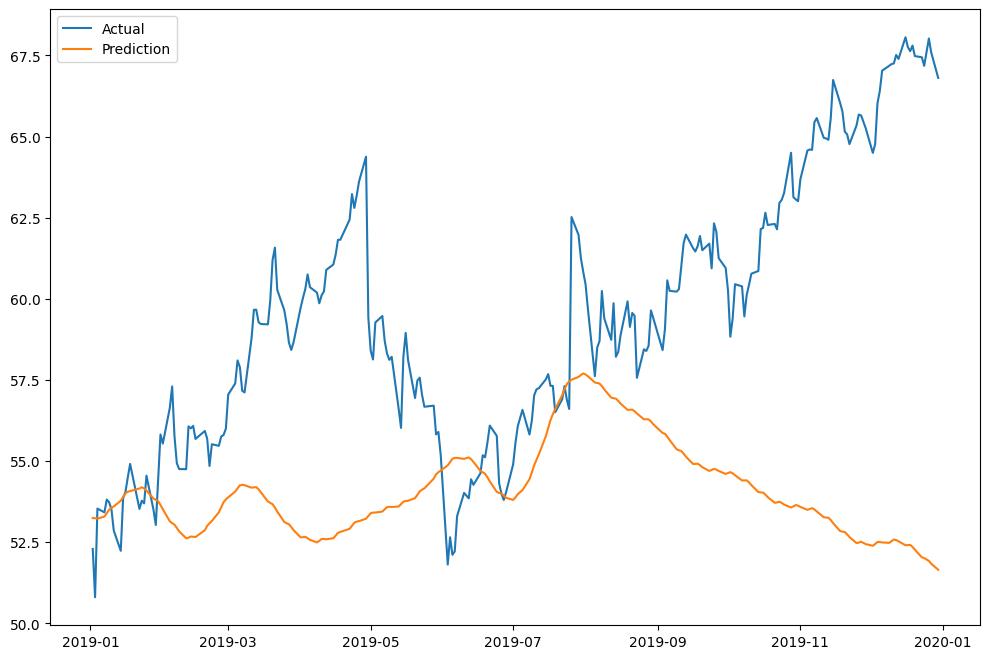

In [35]:
plt.figure(figsize=(12,8))

plt.plot(pd.to_datetime(test1['ds']),test1['y'],label = 'Actual')
plt.plot(pd.to_datetime(test1['ds']),pred1['yhat'],label = 'Prediction')
plt.legend()

In [36]:
results = {'Metric': ['MSE', 'MAE', 'RMSE', 'MAPE'], 'Next 1 Year': [], 'Next 1 Month': [], 'Next 10 Days': []}

In [37]:
# report performance
mse = mean_squared_error(test1['y'], pred1['yhat'])
results['Next 1 Year'].append(mse)
print('MSE: '+str(mse))
mae = mean_absolute_error(test1['y'], pred1['yhat'])
results['Next 1 Year'].append(mae)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test1['y'], pred1['yhat']))
results['Next 1 Year'].append(rmse)
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(pred1['yhat'] - test1['y'])/np.abs(test1['y']))
results['Next 1 Year'].append(mape)
print('MAPE: '+str(mape))

MSE: 49.518637400496374
MAE: 5.48318977874956
RMSE: 7.036948017464416
MAPE: 0.08160099060204458


## TRAIN : 2015 - 2018
## TEST : 2019 FIRST 30 DAYS

In [38]:
train2 = df_prophet[df_prophet['ds'] <= '2018-12-31']
test2 = df_prophet[(df_prophet['ds'] >'2018-12-31') & (df_prophet['ds'] <='2019-1-30') ]


In [39]:
m2 = Prophet(daily_seasonality=True)
m2.fit(train2) # Training
future2 = m2.make_future_dataframe(periods=30) # predict next 30
forecast2 = m2.predict(future2) # Predictions
pd.options.display.max_columns = None
print(forecast2.tail(2))

DEBUG:cmdstanpy:input tempfile: /tmp/tmp4bs0pn2m/kxq4xmqc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4bs0pn2m/7zpatsml.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48715', 'data', 'file=/tmp/tmp4bs0pn2m/kxq4xmqc.json', 'init=/tmp/tmp4bs0pn2m/7zpatsml.json', 'output', 'file=/tmp/tmp4bs0pn2m/prophet_model5miu0pt9/prophet_model-20231103202038.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:20:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:20:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


             ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
1034 2019-01-29  53.232426   51.784902   55.873655    53.076197    53.343408   
1035 2019-01-30  53.228176   51.798796   55.670993    53.052476    53.356509   

      additive_terms  additive_terms_lower  additive_terms_upper    daily  \
1034        0.574147              0.574147              0.574147  1.44772   
1035        0.533751              0.533751              0.533751  1.44772   

      daily_lower  daily_upper    weekly  weekly_lower  weekly_upper  \
1034      1.44772      1.44772  0.062870      0.062870      0.062870   
1035      1.44772      1.44772  0.111521      0.111521      0.111521   

        yearly  yearly_lower  yearly_upper  multiplicative_terms  \
1034 -0.936443     -0.936443     -0.936443                   0.0   
1035 -1.025489     -1.025489     -1.025489                   0.0   

      multiplicative_terms_lower  multiplicative_terms_upper       yhat  
1034                         0.

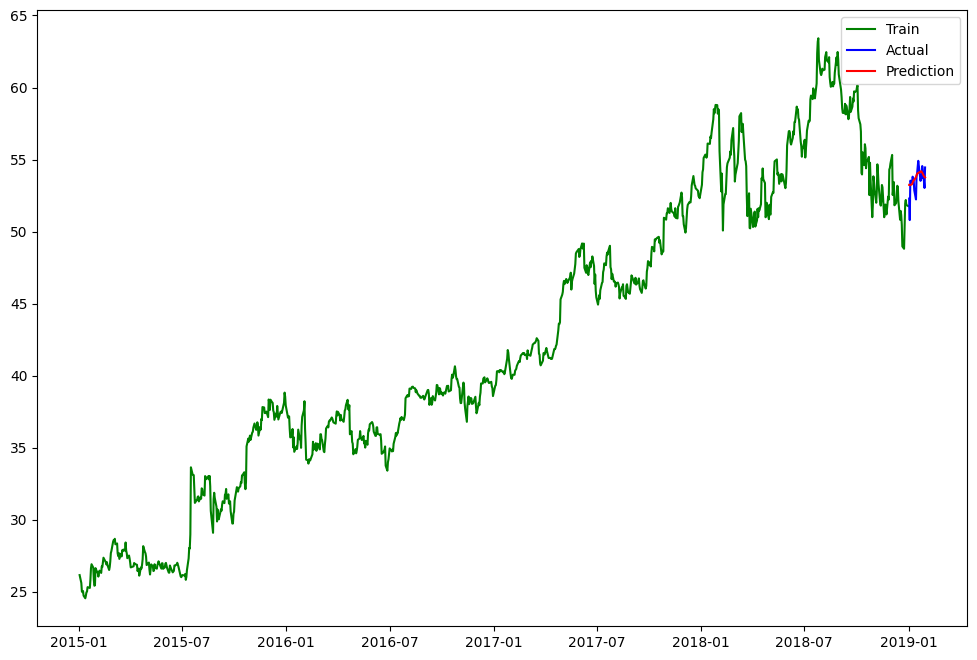

In [40]:
plt.figure(figsize=(12,8))

pred2 = forecast2[forecast2['ds'].isin(test2['ds'])]

plt.plot(pd.to_datetime(train2['ds']),train2['y'],'green',label = 'Train')
plt.plot(pd.to_datetime(test2['ds']),test2['y'],'blue',label = 'Actual')
plt.plot(pd.to_datetime(test2['ds']),pred2['yhat'],'red',label = 'Prediction')
plt.legend()

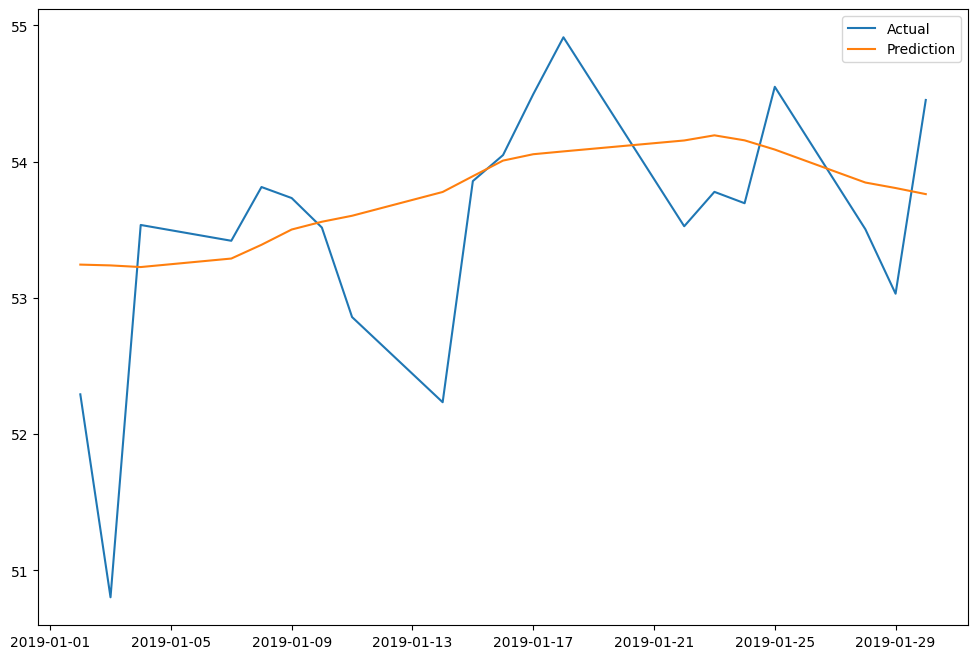

In [41]:
plt.figure(figsize=(12,8))

plt.plot(pd.to_datetime(test2['ds']),test2['y'],label = 'Actual')
plt.plot(pd.to_datetime(test2['ds']),pred2['yhat'],label = 'Prediction')
plt.legend()

In [42]:
# report performance
mse = mean_squared_error(test2['y'], pred2['yhat'])
results['Next 1 Month'].append(mse)
print('MSE: '+str(mse))
mae = mean_absolute_error(test2['y'], pred2['yhat'])
results['Next 1 Month'].append(mae)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test2['y'], pred2['yhat']))
results['Next 1 Month'].append(rmse)
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(pred2['yhat'] - test2['y'])/np.abs(test2['y']))
results['Next 1 Month'].append(mape)
print('MAPE: '+str(mape))

MSE: 0.6604524526796021
MAE: 0.5970887801259718
RMSE: 0.8126822581302007
MAPE: 0.010920585622540172


## TRAIN : 2015 - 2018
## TEST : 2019 FIRST 10 DAYS

In [43]:
train3 = df_prophet[df_prophet['ds'] <= '2018-12-31']
test3 = df_prophet[(df_prophet['ds'] >'2018-12-31') & (df_prophet['ds'] <='2019-1-10') ]


In [44]:
m3 = Prophet(daily_seasonality=True)
m3.fit(train3) # Training
future3 = m3.make_future_dataframe(periods=10) # predict next 10
forecast3 = m3.predict(future3) # Predictions
pd.options.display.max_columns = None
print(forecast3.tail(2))

DEBUG:cmdstanpy:input tempfile: /tmp/tmp4bs0pn2m/2_3k20de.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4bs0pn2m/yk6jgo5m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59188', 'data', 'file=/tmp/tmp4bs0pn2m/2_3k20de.json', 'init=/tmp/tmp4bs0pn2m/yk6jgo5m.json', 'output', 'file=/tmp/tmp4bs0pn2m/prophet_model0v22czi2/prophet_model-20231103202042.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:20:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:20:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


             ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
1014 2019-01-09  53.317429   51.485937   55.502736    53.317429    53.317429   
1015 2019-01-10  53.313179   51.616995   55.535545    53.313179    53.313179   

      additive_terms  additive_terms_lower  additive_terms_upper    daily  \
1014        0.184707              0.184707              0.184707  1.44772   
1015        0.245989              0.245989              0.245989  1.44772   

      daily_lower  daily_upper    weekly  weekly_lower  weekly_upper  \
1014      1.44772      1.44772  0.111521      0.111521      0.111521   
1015      1.44772      1.44772  0.099345      0.099345      0.099345   

        yearly  yearly_lower  yearly_upper  multiplicative_terms  \
1014 -1.374534     -1.374534     -1.374534                   0.0   
1015 -1.301076     -1.301076     -1.301076                   0.0   

      multiplicative_terms_lower  multiplicative_terms_upper       yhat  
1014                         0.

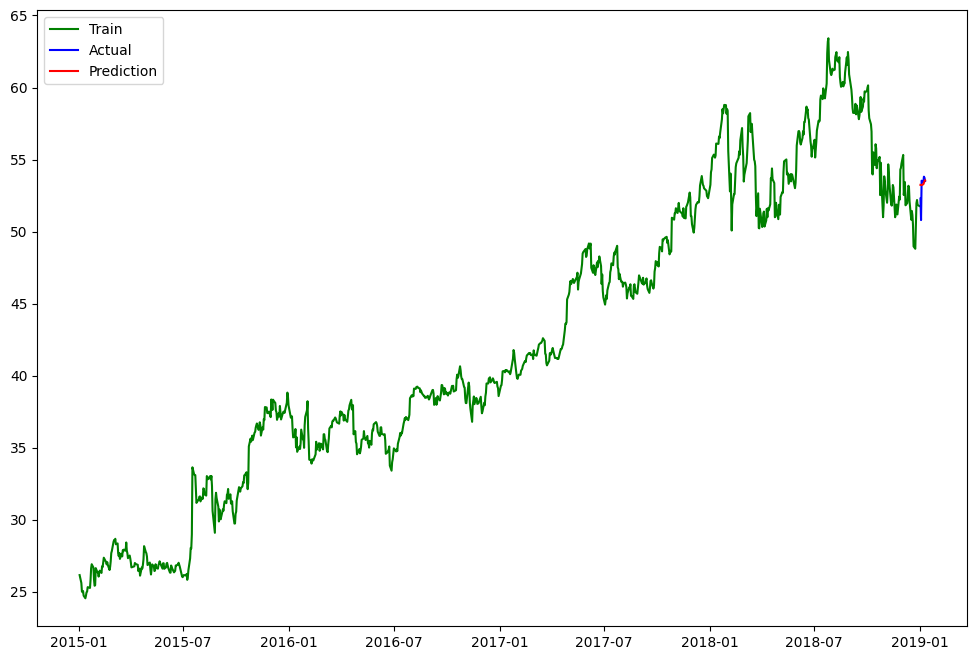

In [45]:
plt.figure(figsize=(12,8))

pred3 = forecast3[forecast3['ds'].isin(test3['ds'])]

plt.plot(pd.to_datetime(train3['ds']),train3['y'],'green',label = 'Train')
plt.plot(pd.to_datetime(test3['ds']),test3['y'],'blue',label = 'Actual')
plt.plot(pd.to_datetime(test3['ds']),pred3['yhat'],'red',label = 'Prediction')
plt.legend()

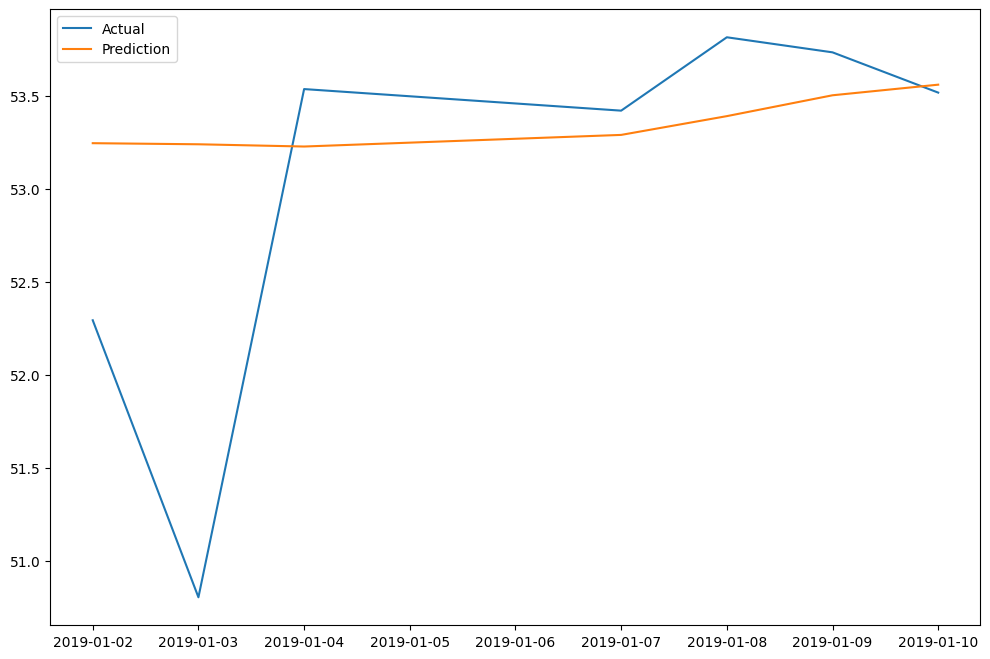

In [46]:
plt.figure(figsize=(12,8))

plt.plot(pd.to_datetime(test3['ds']),test3['y'],label = 'Actual')
plt.plot(pd.to_datetime(test3['ds']),pred3['yhat'],label = 'Prediction')
plt.legend()

In [47]:
# report performance
mse = mean_squared_error(test3['y'], pred3['yhat'])
results['Next 10 Days'].append(mse)
print('MSE: '+str(mse))
mae = mean_absolute_error(test3['y'], pred3['yhat'])
results['Next 10 Days'].append(mae)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test3['y'], pred3['yhat']))
results['Next 10 Days'].append(rmse)
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(pred3['yhat'] - test3['y'])/np.abs(test3['y']))
results['Next 10 Days'].append(mape)
print('MAPE: '+str(mape))

MSE: 1.0266043028252088
MAE: 0.6463662625866574
RMSE: 1.013214835474298
MAPE: 0.015365996834996861


In [48]:
df_results = pd.DataFrame(results)
df_results.set_index('Metric',  inplace=True)
df_results = df_results.apply(lambda x: round(x, 2))
df_results

,Next 1 Year,Next 1 Month,Next 10 Days
Metric,,,
MSE,49.52,0.66,1.03
MAE,5.48,0.60,0.65
RMSE,7.04,0.81,1.01
MAPE,0.08,0.01,0.02


from matplotlib import pyplot as plt
df_results['Next 1 Year'].plot(kind='hist', bins=20, title='Next 1 Year')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_results['Next 1 Month'].plot(kind='hist', bins=20, title='Next 1 Month')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_results['Next 10 Days'].plot(kind='hist', bins=20, title='Next 10 Days')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_results.plot(kind='scatter', x='Next 1 Year', y='Next 1 Month', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_results.plot(kind='scatter', x='Next 1 Month', y='Next 10 Days', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_results['Next 1 Year'].plot(kind='line', figsize=(8, 4), title='Next 1 Year')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_results['Next 1 Month'].plot(kind='line', figsize=(8, 4), title='Next 1 Month')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_results['Next 10 Days'].plot(kind='line', figsize=(8, 4), title='Next 10 Days')
plt.gca().spines[['top', 'right']].set_visible(False)

## TRAIN : 2018

## TEST: 2019 FIRST 30 DAYS

In [49]:
train4 = df_prophet[(df_prophet['ds'] >= '2018-01-01') & (df_prophet['ds'] <= '2018-12-31')]
test4 = df_prophet[(df_prophet['ds'] >'2018-12-31') & (df_prophet['ds'] <='2019-1-30') ]

In [50]:
m4 = Prophet(daily_seasonality=True)
m4.fit(train4) # Training
future4 = m4.make_future_dataframe(periods=30) # predict next 30
forecast4 = m4.predict(future4) # Predictions
pd.options.display.max_columns = None
print(forecast4.tail(2))

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4bs0pn2m/9ue1d4xe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4bs0pn2m/6yahn6bg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4491', 'data', 'file=/tmp/tmp4bs0pn2m/9ue1d4xe.json', 'init=/tmp/tmp4bs0pn2m/6yahn6bg.json', 'output', 'file=/tmp/tmp4bs0pn2m/prophet_model2zaw443w/prophet_model-20231103202044.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:20:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:20:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


            ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
279 2019-01-29  45.060871   45.337957   49.940284    44.604628    45.566748   
280 2019-01-30  44.982586   45.644768   49.932564    44.500061    45.512850   

     additive_terms  additive_terms_lower  additive_terms_upper     daily  \
279        2.561092              2.561092              2.561092  2.547542   
280        2.726527              2.726527              2.726527  2.547542   

     daily_lower  daily_upper    weekly  weekly_lower  weekly_upper  \
279     2.547542     2.547542  0.013549      0.013549      0.013549   
280     2.547542     2.547542  0.178985      0.178985      0.178985   

     multiplicative_terms  multiplicative_terms_lower  \
279                   0.0                         0.0   
280                   0.0                         0.0   

     multiplicative_terms_upper       yhat  
279                         0.0  47.621962  
280                         0.0  47.709113  


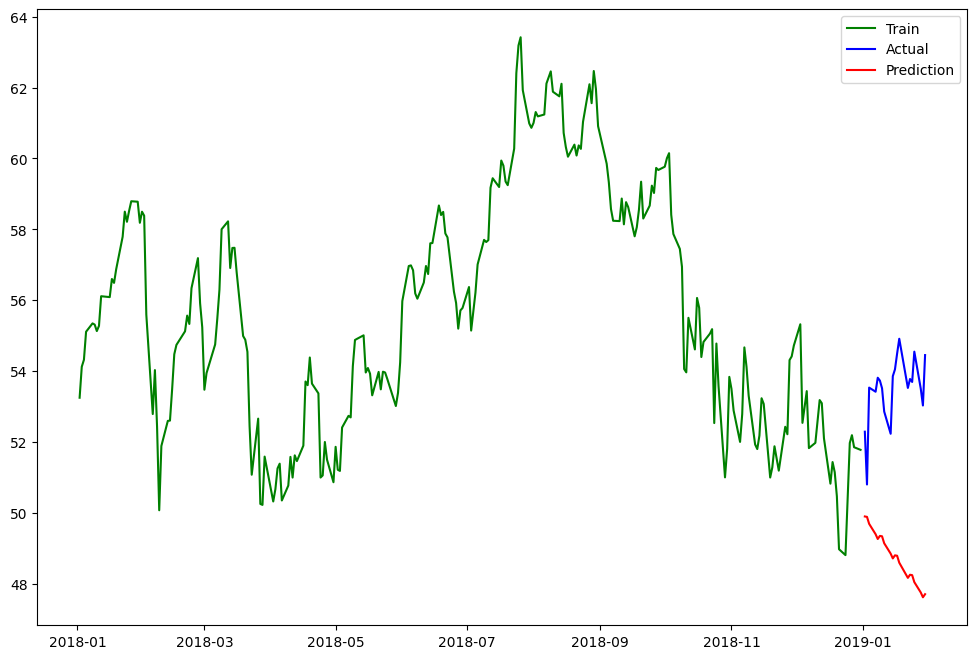

In [51]:
plt.figure(figsize=(12,8))

pred4 = forecast4[forecast4['ds'].isin(test4['ds'])]

plt.plot(pd.to_datetime(train4['ds']),train4['y'],'green',label = 'Train')
plt.plot(pd.to_datetime(test4['ds']),test4['y'],'blue',label = 'Actual')
plt.plot(pd.to_datetime(test4['ds']),pred4['yhat'],'red',label = 'Prediction')
plt.legend()

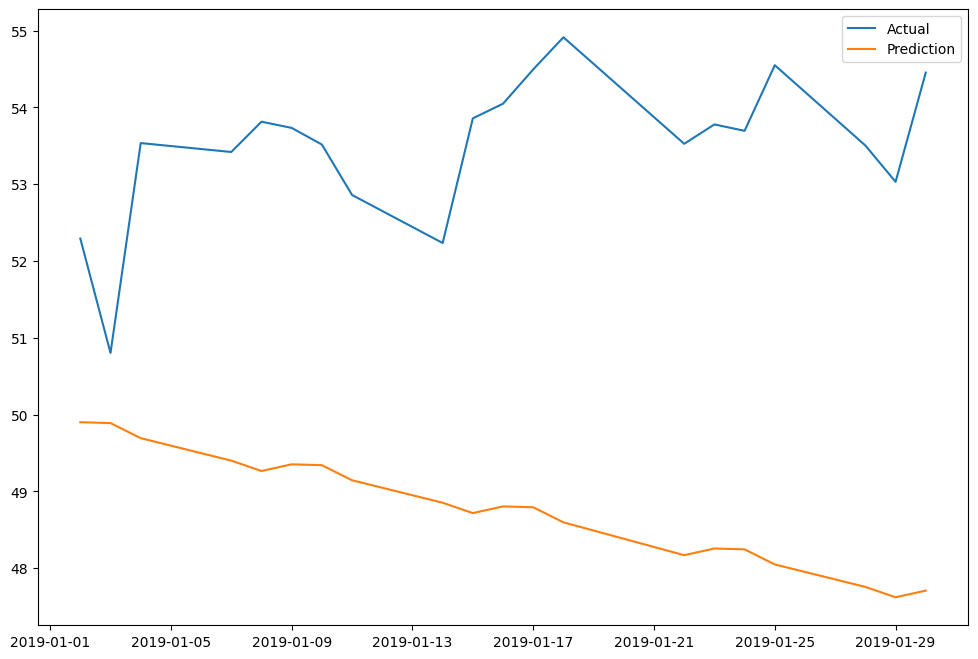

In [52]:
plt.figure(figsize=(12,8))

plt.plot(pd.to_datetime(test4['ds']),test4['y'],label = 'Actual')
plt.plot(pd.to_datetime(test4['ds']),pred4['yhat'],label = 'Prediction')
plt.legend()

In [53]:
# report performance
mse = mean_squared_error(test4['y'], pred4['yhat'])
print('MSE: '+str(mse))
mae = mean_absolute_error(test4['y'], pred4['yhat'])
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test4['y'], pred4['yhat']))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(pred4['yhat'] - test4['y'])/np.abs(test4['y']))
print('MAPE: '+str(mape))

MSE: 24.258147164872263
MAE: 4.7244504488169135
RMSE: 4.925256050691401
MAPE: nan


## MULTIVARIATE PROPHET


In [54]:
df_prophet_multi = data
df_prophet_multi = df_prophet_multi.reset_index()
df_prophet_multi

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,26.378078,26.490770,26.133251,26.168653,26.168653,28951268
1,2015-01-05,26.091366,26.144720,25.582764,25.623152,25.623152,41196796
2,2015-01-06,25.679497,25.738087,24.983908,25.029282,25.029282,57998800
3,2015-01-07,25.280592,25.292759,24.914099,24.986401,24.986401,41301082
4,2015-01-08,24.831326,25.105074,24.482782,25.065184,25.065184,67071641
...,...,...,...,...,...,...,...
1252,2019-12-23,67.793503,67.989998,67.325500,67.442001,67.442001,17662000
1253,2019-12-24,67.425003,67.513000,67.139000,67.178001,67.178001,6950000
1254,2019-12-26,67.308502,68.066353,67.223503,68.019997,68.019997,13350000
1255,2019-12-27,68.149498,68.226501,67.465500,67.594498,67.594498,20768000
